# Analytics

**Date: 2021/1**

**SUMMARY:**
    
   * This notebook represents the project quality analysis of the date exposed right above
    
### TEAM:

**Semester: 2021/1**

**Professor: Hilmer Neri**

**Members:**

* Artur Vinicius Dias Nunes
* Eduardo Vieira Lima
* Gabriel Marques Tiveron
* João Pedro de Aquino Corrêa Martins
* Levi de Oliveira Queiroz
* Luís Henrique Pereira Taira
* Nicolas Georgeos Mantzos

### LIBRARIES

In [1]:
import requests
import json
import utils.constants as CONST
import utils.widgets as WDG
import ipywidgets as widgets
import time
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import os
import datetime

#### Dataframe Config

In [2]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### **SonarCloud**

**Path to metrics files: ../analytics-raw-data/**

In [3]:
jsons = glob('../analytics-raw-data/*.json')

In [4]:
def read_json(json_):
    
    with open(json_) as json_file:
        json_obj = json.load(json_file)
            
    return json_.split('/')[-1], json_obj

def create_base_df(json_list):
    
    df = pd.DataFrame()
    
    for i in json_list:
        
        file_name, data = read_json(i)
        
        df_ = pd.DataFrame(data['baseComponent']['measures'])
        
                          
        df_['file_name'] = file_name
                  
        df = df.append(df_, ignore_index=True)
        
    aux_df = df['file_name'].str.split(r'fga-eps-mds-2021_1-PUMA-([a-zA-Z]+)-([\d-]+).json', expand=True)
    
    df['repository'] = aux_df[1]
    
    df['date'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'date']).drop(['file_name'], axis=1)

    return df

In [5]:
df = create_base_df(jsons)

In [6]:
df.head(10)

,metric,value,bestValue,repository,date
88,duplicated_lines_density,0.0,True,ApiGateway,10-06-2021-15-49
89,functions,21,NaN,ApiGateway,10-06-2021-15-49
90,security_rating,1.0,True,ApiGateway,10-06-2021-15-49
91,files,7,NaN,ApiGateway,10-06-2021-15-49
92,complexity,22,NaN,ApiGateway,10-06-2021-15-49
93,ncloc,92,NaN,ApiGateway,10-06-2021-15-49
94,reliability_rating,1.0,True,ApiGateway,10-06-2021-15-49
95,comment_lines_density,2.1,False,ApiGateway,10-06-2021-15-49
24,files,19,NaN,ApiGateway,11-08-2021-06-54
25,ncloc,797,NaN,ApiGateway,11-08-2021-06-54


In [7]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [8]:
def metric_per_file(json):
    
    file_json = []
        
    for component in json[1]['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'js')

        file_component_df['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021_1-PUMA-([a-zA-Z]+)-([\d-]+).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version']).drop(['filename'], axis=1)
        
    return df

In [9]:
file_component = create_file_df(jsons).fillna(0)
file_component = file_component.sort_values('version')

In [10]:
REPOS = ['UserService', 'ProjectService', 'Frontend', 'ApiGateway']

In [11]:
dfs = {}
for repo in REPOS:
    dfs[repo] = file_component[file_component['repository'] == repo]
    dfs[repo].fillna(0)

In [12]:
file_component.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,repository,version
67,dbconfig/dbConfig.js,3,8,7.9,0.0,0,35,1.0,0,100.0,0.0,1.0,UserService,10-06-2021-15-47
68,dbconfig/dbSchema.js,0,0,0.0,0.0,0,147,1.0,0,100.0,0.0,1.0,UserService,10-06-2021-15-47
69,src/config/environment.js,1,2,0.0,0.0,0,9,1.0,0,100.0,0.0,1.0,UserService,10-06-2021-15-47
70,src/index.js,0,0,5.6,0.0,0,17,1.0,0,100.0,0.0,1.0,UserService,10-06-2021-15-47
76,src/routes/userRouter.js,8,8,0.0,0.0,0,31,1.0,0,100.0,0.0,1.0,UserService,10-06-2021-15-47
75,src/repository/userRepository.js,22,23,2.2,0.0,0,90,1.0,0,100.0,0.0,1.0,UserService,10-06-2021-15-47
74,src/controller/userController.js,3,11,2.3,0.0,0,43,1.0,0,100.0,0.0,1.0,UserService,10-06-2021-15-47
73,src/models/user.js,0,0,100.0,0.0,0,0,1.0,0,100.0,0.0,1.0,UserService,10-06-2021-15-47
72,tests/tests.js,0,0,100.0,0.0,0,0,1.0,0,100.0,0.0,1.0,UserService,10-06-2021-15-47
71,src/routes/router.js,2,2,0.0,0.0,0,11,1.0,0,100.0,0.0,1.0,UserService,10-06-2021-15-47


In [13]:
def _nloc(df):
    ncloc = 0
    for each in df['ncloc']:
        ncloc += int(each)

    return ncloc

In [14]:
def m1(df):
    return len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)

In [15]:
def m2(df):
    return len(df[(df['comment_lines_density'].astype(float) > 10) &\
                  (df['comment_lines_density'].astype(float) < 30)])/len(df)

In [16]:
def m3(df):
    return len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)

In [17]:
def m4(df):
    return df['test_success_density'].astype(float).median() / 100

In [18]:
def m5(df):
    if sum(df['tests'].astype(float)) > 0:
        return len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))
    else:
        return 0

In [19]:
def m6(df):
    return len(df[(df['coverage'].astype(float) > 60)])\
            / len(df[(df['path'].str.contains('src')) & (~df['path'].str.contains('config'))])

In [20]:
def create_metrics(df):
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []
    
    ncloc_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:
        
        version_df = df[df['version'] == version]
        
        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m4(version_df))
        m5_list.append(m5(version_df))
        m6_list.append(m6(version_df))
        
        ncloc_list.append(_nloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
    
    metrics_df = pd.DataFrame({
            'm1': m1_list,
            'm2': m2_list,
            'm3': m3_list,
            'm4': m4_list,
            'm5': m5_list,
            'm6': m6_list,
            'repository': repository_list, 
            'version': version_list,
            'ncloc': ncloc_list})
    
    return metrics_df

In [21]:
def plot_metrics(df):
    fig = plt.figure(figsize=(20, 10))
#     ax = subplot(1,1,1)

    plt.plot(df['m1'], linewidth=3, marker='o', markersize=10, label='complexity')
    plt.plot(df['m2'], linewidth=3, marker='o', markersize=10, label='comment lines')
    plt.plot(df['m3'], linewidth=3, marker='o', markersize=10, label='duplicate')
    plt.plot(df['m4'], linewidth=3, marker='o', markersize=10, label='test success')
    plt.plot(df['m5'], linewidth=3, marker='o', markersize=10, label='test execution time')
    plt.plot(df['m6'], linewidth=3, marker='o', markersize=10, label='test coverage')
#     handles, labels = ax.get_legend_handles_labels()
    fig.legend(loc='lower center')
    plt.show()

In [22]:
def drop_unwanted(df):
    new_df = df[~df['path'].str.contains('test')]
    new_df = new_df[~new_df['path'].str.contains('config')]
    new_df = new_df[~new_df['path'].str.contains('db')]
    new_df = new_df[~new_df['path'].str.contains('index')]
    new_df = new_df[~new_df['path'].str.contains('endpoint')]
    return new_df

In [23]:
for repo in REPOS:
    dfs[repo] = drop_unwanted(dfs[repo])

In [24]:
from IPython.display import display, Markdown, Latex
from utils.analysis import ANALYSIS

output = []
for i in range(len(REPOS)):
    output.append(widgets.Output())

tab = widgets.Tab(children = output)

for i in range(len(REPOS)):
    tab.set_title(i, REPOS[i])

display(tab)

metrics = {}

for i in range(len(REPOS)):
    metrics[REPOS[i]] = create_metrics(dfs[REPOS[i]]) 
    with output[i]:  
        plot_metrics(metrics[REPOS[i]])
        display(Markdown(ANALYSIS[REPOS[i]]))

In [25]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

for repo in REPOS:

    metrics[repo]['code_quality'] = ((metrics[repo]['m1']*pm1) + (metrics[repo]['m2']*pm2) + (metrics[repo]['m3']*pm3)) * psc1
    metrics[repo]['testing_status'] = ((metrics[repo]['m4']*pm4) + (metrics[repo]['m5']*pm5) + (metrics[repo]['m6']*pm6)) * psc2


In [26]:
output = []
for i in range(len(REPOS)):
    output.append(widgets.Output())

tab = widgets.Tab(children = output)

for i in range(len(REPOS)):
    tab.set_title(i, REPOS[i])

display(tab)

for i in range(len(REPOS)):
    with output[i]:
        fig = plt.figure(figsize=(20, 10))
        plt.plot(metrics[REPOS[i]]['code_quality'], linewidth=3, marker='o', markersize=5, label='code_quality')
        plt.plot(metrics[REPOS[i]]['testing_status'], linewidth=3, marker='s', markersize=5, label='testing_status')
        fig.legend(loc='lower center')
        plt.show()

In [27]:
metrics_df = pd.concat([i for i in metrics.values()], ignore_index=True)
metrics_df['maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['maintainability'] + metrics_df['Reliability']

In [28]:
metrics_df = metrics_df.sort_values('version')
metrics_df

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,maintainability,Reliability,total
0,0.800000,0.0,1.0,1.000,0.000000,0.000000,UserService,10-06-2021-15-47,175,0.594000,0.150000,0.297000,0.075000,0.372000
10,1.000000,0.0,1.0,1.000,0.000000,0.000000,ApiGateway,10-06-2021-15-49,72,0.660000,0.150000,0.330000,0.075000,0.405000
7,0.333333,0.0,1.0,1.000,0.000000,0.000000,Frontend,10-06-2021-15-50,210,0.440000,0.150000,0.220000,0.075000,0.295000
4,0.000000,0.0,1.0,1.000,0.000000,0.000000,ProjectService,10-19-2021-01-07,0,0.330000,0.150000,0.165000,0.075000,0.240000
1,0.800000,0.0,1.0,1.000,0.000000,0.000000,UserService,10-29-2021-21-16,206,0.594000,0.150000,0.297000,0.075000,0.372000
8,0.437500,0.0,1.0,1.000,0.000000,0.000000,Frontend,10-29-2021-21-53,376,0.474375,0.150000,0.237187,0.075000,0.312188
5,0.600000,0.0,1.0,1.000,0.000000,0.000000,ProjectService,10-29-2021-21-54,101,0.528000,0.150000,0.264000,0.075000,0.339000
9,0.625000,0.0,1.0,1.000,0.000000,0.000000,Frontend,10-29-2021-22-20,414,0.536250,0.150000,0.268125,0.075000,0.343125
2,0.800000,0.0,1.0,1.000,0.185185,0.000000,UserService,11-07-2021-01-05,201,0.594000,0.177778,0.297000,0.088889,0.385889
3,1.000000,0.0,1.0,0.505,0.148148,0.500000,UserService,11-08-2021-04-09,201,0.660000,0.447972,0.330000,0.223986,0.553986


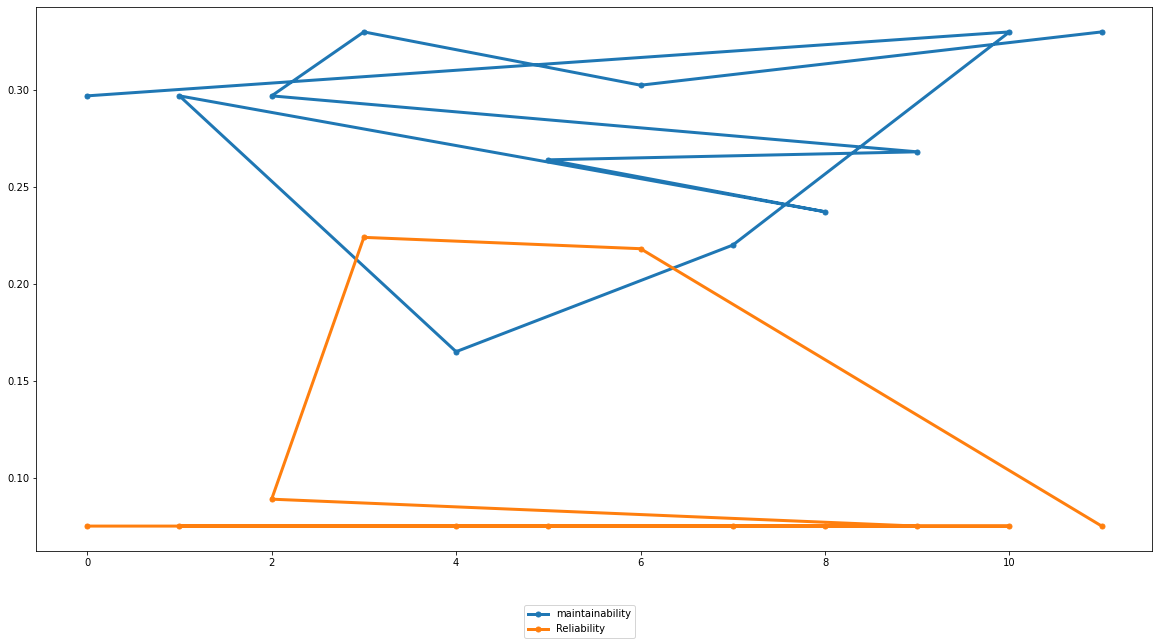

In [29]:
fig = plt.figure(figsize=(20, 10))


plt.plot(metrics_df['maintainability'], linewidth=3, marker='o', markersize=5, label='maintainability')
plt.plot(metrics_df['Reliability'], linewidth=3, marker='o', markersize=5, label='Reliability')
fig.legend(loc='lower center')
# plt.ylim(.45,.7)
plt.show()


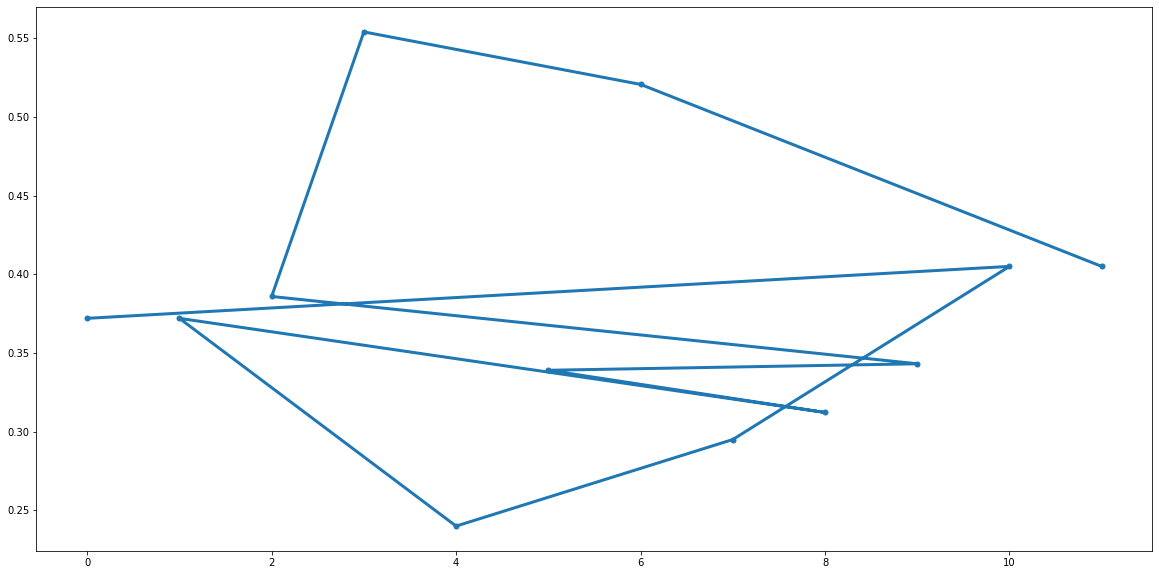

In [30]:
fig = plt.figure(figsize=(20, 10))


plt.plot(metrics_df['total'], linewidth=3, marker='o', markersize=5)


# plt.ylim(.45,.7)
plt.show()

## Análise da qualidade total

No geral, a qualidade de código, baseado nas métricas colhidas em cada release, se mostra abaixo do esperado
Pois foi necessária a priorização das entregas acima das testagens e refatoração.

Dessa forma, é possível observar dois picos na qualidade total do projeto, que justamente são dos testes realizados nos serviços de usuário e de projeto. 

É possível ver claramente o impacto das decisões tomadas pela equipe durante o período de execução do projeto, desde o atraso nas entregas de US's, a priorização dessas entregas e, por fim, o desenvolvimento dos testes unitários.

In [31]:
# ANALYSIS_DATE FORMAT: YYYY-MM-DD
currentTime = datetime.datetime.now().strftime("%Y-%m-%d")

metrics_df.to_excel('data/fga-eps-mds-NOME_PROJETO-DATASET-{}.xlsx'.format(currentTime), index = False)
metrics_df.to_csv('data/fga-eps-mds-NOME_PROJETO-DATASET-{}.csv'.format(currentTime), index = False)

ModuleNotFoundError: No module named 'openpyxl'